# [Exploration 14] 흉부 X-Ray 사진을 보고 폐렴 진단 모델 만들기

## Step 1. 실험환경 Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

필요한 모듈 준비

In [25]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 50

print(ROOT_PATH)

/home/aiffel-dj58/aiffel


앞으로 필요한 변수 세팅

## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [21]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1086
Pneumonia images count in training set: 3099


train data속에 비폐렴의 이미지수와 폐렴의 이미지 수를 정해놓는다.

In [4]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [5]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


다시 한번 더 Train set꽈 Validation set의 갯수 확인?

In [6]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


레이블 이름 확인

In [7]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

레이블 데이터를 만들어주는 함수 생성

In [8]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)


In [9]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

이미지 리사이징 및 JPEG형태로 decode하고, float형태로 바꿔준다.

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

`num_parallel_calls`에서 AUTOTUNE을 사용하면 데이터 처리를 더욱 빠르게 할 수 있다고 한다.

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


이미지 한개를 확인해보면 180, 180으로 리사이즈가 되었고, Label은 True를 나타내고 있다.

In [12]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


test set에도 동일하게 전처리를 해준다.

## Step 3. 데이터 시각화

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

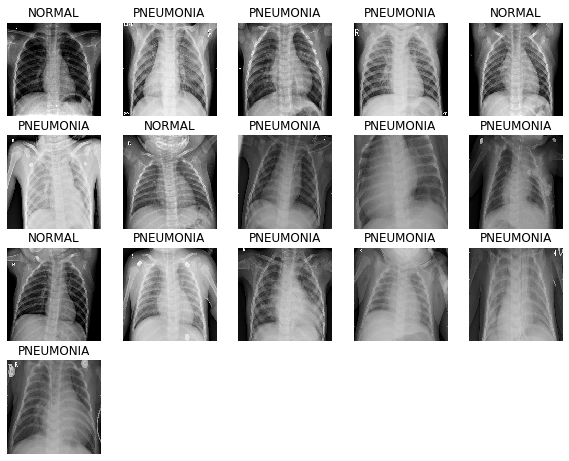

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

필터를 매개변수로하는 convolutional block을 먼저 설정해준다.   
BatchNormalization과 Maxpooling까지 포함되어 있다.

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

입력되는 input 사이즈와 dropout을 매개변수로하는 dense_block도 설정하여 준다.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

모델함수를 설정한다.

## Step 5. 데이터 imbalance 처리

In [26]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


imbalance한 데이터를 다루기 위해서 폐렴이 아닌 경우가 데이터셋이 더 적으므로 로스값에 가중치를 더해준다.

## Step 6. 모델 훈련

In [27]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

앞서 선언하였던 `build_model`을 사용하여 모델을 불러온다.   
성과 측정을 위해서 accuracy와 precisoin, recall값을 확인한다.   
optimizer로는 adam, loss는 폐렴 유무를 측정하므로 binary_crossentropy를 사용한다.

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
261/261 [==============================] - 24s 92ms/step - loss: 0.4278 - accuracy: 0.7974 - precision: 0.9467 - recall: 0.7698 - val_loss: 0.6382 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 24s 92ms/step - loss: 0.2331 - accuracy: 0.9068 - precision: 0.9760 - recall: 0.8961 - val_loss: 1.0059 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 24s 93ms/step - loss: 0.2051 - accuracy: 0.9267 - precision: 0.9758 - recall: 0.9240 - val_loss: 0.1696 - val_accuracy: 0.9394 - val_precision: 0.9554 - val_recall: 0.9640
Epoch 4/50
261/261 [==============================] - 24s 92ms/step - loss: 0.1954 - accuracy: 0.9284 - precision: 0.9797 - recall: 0.9224 - val_loss: 0.7417 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 5/50
261/261 [==============================] - 23s 87ms/step - loss: 0.1894 - accuracy: 0

Epoch 37/50
261/261 [==============================] - 23s 87ms/step - loss: 0.1092 - accuracy: 0.9629 - precision: 0.9916 - recall: 0.9578 - val_loss: 0.0648 - val_accuracy: 0.9712 - val_precision: 0.9857 - val_recall: 0.9756
Epoch 38/50
261/261 [==============================] - 22s 86ms/step - loss: 0.0767 - accuracy: 0.9686 - precision: 0.9940 - recall: 0.9636 - val_loss: 0.0954 - val_accuracy: 0.9606 - val_precision: 0.9986 - val_recall: 0.9487
Epoch 39/50
261/261 [==============================] - 23s 88ms/step - loss: 0.0722 - accuracy: 0.9746 - precision: 0.9934 - recall: 0.9723 - val_loss: 0.0494 - val_accuracy: 0.9827 - val_precision: 0.9897 - val_recall: 0.9871
Epoch 40/50
261/261 [==============================] - 23s 87ms/step - loss: 0.0617 - accuracy: 0.9801 - precision: 0.9934 - recall: 0.9796 - val_loss: 0.0608 - val_accuracy: 0.9769 - val_precision: 1.0000 - val_recall: 0.9691
Epoch 41/50
261/261 [==============================] - 23s 87ms/step - loss: 0.0452 - accura

Epoch값을 50으로 학습을 진행하였는데 정확도와 loss 등의 METRICS값들이 안정적으로 학습되고 있는 것을 확인하였다.

## Step 7. 결과 확인과 시각화

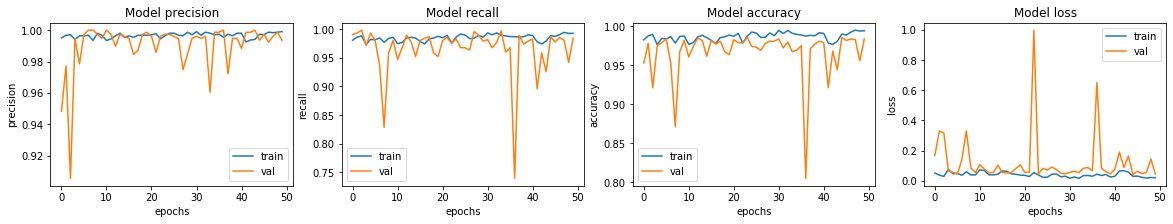

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

한번씩 튀어오르는 부분들이 있었지만 전반적으로 문제없이 학습이 잘 진행되어 꽤 높은 값의 정확도와 로스를 얻을 수 있었다.

Augmentation을 진행하기 전의 그래프와 비교해보면 로스는 비슷한 모양을 보이지만, 다른 값들은 꽤 안정적으로 학습되었다는 것을 알 수 있다.

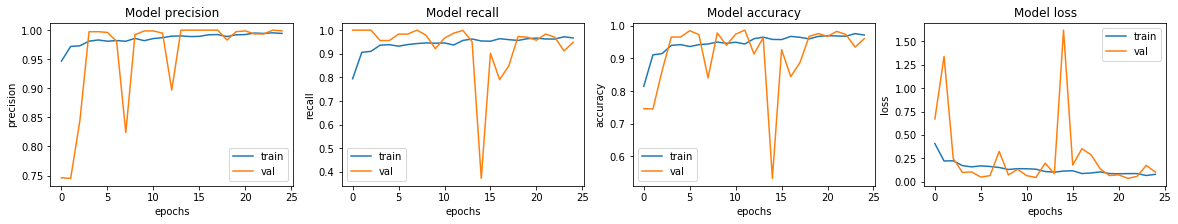

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- 코드를 사용하는데 tensorflow 메서드를 활용하는 코드들이 많아 직관적으로 이해가 안되서 어려운 부분들이 있었다.   
- augmentation이 어떤식으로 진행되었는지 잘 이해하지 못했다.
   
   
## 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
- imbalance한 데이터를 어떻게 다뤄야하는지 배우게 되었다.   
- 폐렴진단 데이터셋의 경우에도 노말인 경우가 폐렴인 경우보다 훨씬 많았는데 이런 불균형 데이터의 경우의 precision과 recall값을 보는것도 흥미로웠다.

## 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
1. 정확도, precision, recall값을 확인하며 시각화 하였다.
2. regularization, augmentation을 사용하였다
3. Accuracy가 85%이상 달성하였다.


## 4. **자기 다짐**   
코드가 난해하고 어려웠던 점을 제외하면 흥미로운 노드였다. 의학분야의 데이터를 이런식으로 활용할 수 있다는 것을 배웠고, 파생된 문제점과 해결하지 못한 부분에 대해서도 생각해보게 되었다 (예를 들면, 개인정보문제).   
현재 인간이 폐렴을 정확하게 분류할 확률이 90% 이상이라고 하지만, 의학과 인공지능이 결합한다면 확실히 좋은 결과물을 가져올 수 있을것으로 기대한다.
   